In [191]:
import pandas as pd
import numpy as np
import zipfile  
import json
import seaborn as sns 

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.2f}'.format

seed=42
np.random.seed = 42

### Parsing

In [5]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [7]:
#train
jsonsList_train =  []
with zipfile.ZipFile("data/raw/source-4-ds-train.json.zip", "r") as z:
    for filename in z.namelist():  
        with z.open(filename) as f:  
            for line in f:
                jsonsList_train.append(flatten_json(json.loads(line)))
dataset_train = pd.DataFrame(data=jsonsList_train)
dataset_train.to_csv('data/processed/train.csv.gzip', sep =';', index=False,  compression="gzip")

In [8]:
#test
jsonsList_test =  []
with zipfile.ZipFile("data/raw/source-4-ds-test.json.zip", "r") as z:
    for filename in z.namelist():  
        with z.open(filename) as f:
            for line in f:
                jsonsList_test.append(flatten_json(json.loads(line)))
dataset_test = pd.DataFrame(data=jsonsList_test)
dataset_test.to_csv('data/processed/test.csv.gzip', sep =';', index=False, compression='gzip')

### Exploring and cleaning

In [210]:
dataset = pd.read_csv('data/processed/train.csv.gzip',compression='gzip', sep =';',decimal=',')

# filtro de apenas apartamentos e vendas como está no enunciado
dataset = dataset[dataset['unitTypes']=='APARTMENT']
dataset = dataset[dataset['pricingInfos_businessType']=='SALE']

dataset.sample(1)

/home/villy/Desktop/git/imoveis/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (10,13,22,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_geoLocation_precision,address_geoLocation_location_lon,address_geoLocation_location_lat,address_street,address_locationId,address_district,address_unitNumber,address_state,address_neighborhood,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos_price,pricingInfos_businessType,pricingInfos_period,pricingInfos_yearlyIptu,pricingInfos_rentalTotalPrice,pricingInfos_monthlyCondoFee
51062,173.0,Apartamento com excelente padrão de acabamento...,"Apartamento residencial à venda, Jardim Análi...",2016-10-07T04:55:18Z,8c5fadc679,APARTMENT,ACTIVE,ad0f3393ce,6.0,2019-02-24T22:35:01.194Z,False,['http://cdn1.valuegaia.com.br/watermark/agenc...,NaN,"3,309,060.00",São Paulo,600,NaN,ROOFTOP,-46.562256,-23.549247,Rua Antônio Camardo,BR>Sao Paulo>NULL>Sao Paulo>Zona Leste>Jardim ...,NaN,NaN,São Paulo,Vila Gomes Cardim,3.0,STANDARD,4.0,369.0,3.0,1295000,SALE,NaN,0.0,NaN,909.0


#### Limpando 

In [211]:
def describe():
    """
    helper para achar valores estranhos nas pontas, máx e mín
    """
    num_lit = ['usableAreas','pricingInfos_price','parkingSpaces','suites','bathrooms'
    ,'totalAreas','bedrooms','pricingInfos_yearlyIptu','pricingInfos_monthlyCondoFee']

    return dataset[num_lit].describe()

In [212]:
#garantindo o float dtype
dataset = dataset[~dataset['usableAreas'].astype(str).str.contains('[A-Za-z]', na=False)]  
dataset['usableAreas'] = dataset['usableAreas'].astype('float32')

dataset = dataset[~dataset['pricingInfos_price'].astype(str).str.contains('[A-Za-z]', na=False)]    
dataset['pricingInfos_price'] = dataset['pricingInfos_price'].astype('float')

dataset['parkingSpaces']=dataset['parkingSpaces'].astype('float32')
dataset['suites']=dataset['suites'].astype('float')
dataset['bathrooms']=dataset['bathrooms'].astype('float')
dataset['totalAreas']=dataset['totalAreas'].astype('float')
dataset['bedrooms']=dataset['bedrooms'].astype('float')
dataset['pricingInfos_price']=dataset['pricingInfos_price'].astype('float')
dataset['pricingInfos_yearlyIptu']=dataset['pricingInfos_yearlyIptu'].astype('float')
dataset['pricingInfos_monthlyCondoFee']= dataset['pricingInfos_monthlyCondoFee'].astype('float')



"""
arrumando pontos na mão pois parece um misstype dado a metragem da casa, área e preço
foi feito a partir do helper describe()
"""
dataset.loc[91598,'usableAreas'] = 129 #misstype 
dataset.loc[3076,'pricingInfos_price'] = 7420000.00 #misstype 
dataset.loc[67986,'usableAreas'] = 90.00 #misstype 
dataset.loc[127253,'pricingInfos_price'] = 254349.20 #preço do m2 em tatuapé
dataset.loc[91030,'pricingInfos_price'] = 2240000.00 
dataset.loc[95790,'pricingInfos_price'] = 2072000.00
dataset.loc[16201,'usableAreas'] = 192.58 #misstype 
dataset.loc[16201,'totalAreas'] = 192.58 #misstype 
dataset.loc[28040,'totalAreas']=320.80 #misstype 
dataset.loc[120825,'totalAreas']=547.50 #misstype 
dataset.loc[10122,'bathrooms']=2 #mediana pois é área é de 65m²
dataset.loc[88364,'suites']=3 # #misstype 
dataset.loc[114508,'bedrooms']=2 #misstype 
dataset.loc[85067,'bedrooms']=3 #misstype 
dataset.loc[74140,'bedrooms']=2 #misstype 
dataset.loc[129094,'bedrooms']=1 #misstype 
dataset.loc[4875,'pricingInfos_yearlyIptu']=103670.00 #misstype 
dataset.loc[29837,'pricingInfos_yearlyIptu']=80499.99 #misstype 
dataset.loc[109411,'pricingInfos_yearlyIptu']=1610.00 #misstype 
dataset.loc[104816,'pricingInfos_monthlyCondoFee']=2443 #misstype 

"""
essa lista me pareceu que foi input errado, e como os valores estam perto da média
"""
bathLocs_list=[12128,34455,40067,71233,74140,87137,93715,100627,111310]
valor_list = [3,2,2,3,2,4,2,2,5]
dataset.loc[[x for x in bathLocs_list ],'bathrooms'] = [x for x in valor_list]

"""
misstype ou erro de processamento, valores 10x maiores
"""
dataset['pricingInfos_yearlyIptu'] = dataset['pricingInfos_yearlyIptu'].apply(lambda x: x/10 if x>100000 else x )
dataset['pricingInfos_price'] = dataset['pricingInfos_price'].apply(lambda x: x/10 if x > 10000000 else x)

In [213]:
#banheiros
bathLocs_list = [5148,5642,22853,52435,56737,64387,104721]
dataset.loc[[x for x in bathLocs_list],'bathrooms']=4 #mediana de num de banheiros em casas dessa metragem (120m²+)


#garantindo que não haja totalAreas muito distantes da usableAreas
def usableArea(x):
    if x['totalAreas']*3 > x['usableAreas']:
        return x['usableAreas']
    else:
        return x['totalAreas']    
dataset['totalAreas'] = dataset[['totalAreas','usableAreas']].apply(usableArea, axis=1)


#olhando o preço médio de um imóvel com mais de 1500m2, nos sites de imóvel, percebe-se que há poucos que custam menos de 2m
def usableArea2(x):
    if x['usableAreas'] > 1500 and x['pricingInfos_price'] < 2000000:
        return x['usableAreas']/10
    else:
        return x['totalAreas']
dataset[['usableAreas']]=dataset[['usableAreas','totalAreas','pricingInfos_price']].apply(usableArea2, axis=1)


#olhando parkingSpaces
"""
como que a maioria dos aps tem entre 1 e 3 vagas, vamos achar a distribuição e usar como probabilidade para trazer para
um valor mais realista

assim um dataset['parkingSpaces'].value_counts() pode nos dar uma boa aproximação
"""
def randomParkingSpaces():
    p = [0.051824852372388,0.473013194963949,0.286341859391663
        ,0.104668375061677,0.060483550066054,0.017317395387334
        ,0.006350772756936]
    values = [0,1,2,3,4,5,6]

    return np.random.choice(values,1,p=p,)[0]
dataset['parkingSpaces'] = dataset['parkingSpaces'].apply(lambda x: randomParkingSpaces() if x>29 else x)


In [214]:
#Condomínios na ordem de 10^9 não fazem sentindo então temos um valor máximo na faixa de 2k
#[fonte] https://imoveis.estadao.com.br/noticias/jardins-e-moema-sao-os-bairros-com-condominios-mais-caros-de-sao-paulo/
dataset['pricingInfos_monthlyCondoFee'] = dataset['pricingInfos_monthlyCondoFee'].apply(lambda x: x/1000 if x > 1000000 else x)
def value(x):
    if x['pricingInfos_monthlyCondoFee']>5000 and x['pricingInfos_price']<2000000:
        return x/10
    else:
        return x
    
dataset[['pricingInfos_monthlyCondoFee','pricingInfos_price']] = dataset[['pricingInfos_monthlyCondoFee','pricingInfos_price']].apply(value,axis =1)

In [157]:
#extraindo info do title via Regex
dataset[['usableAreasFromTitle','a']] = dataset['title'].str.extract('(\d{1,4}\s?(m²|metros quadrados|metros quadrado),?)', expand=False)
dataset[['vagaFromTitle', 'b']]= dataset['title'].str.extract('(\s?\d{1,2}\s?(vaga|vagas|estacionamento))', expand=False)


In [215]:
describe()

,usableAreas,pricingInfos_price,parkingSpaces,suites,bathrooms,totalAreas,bedrooms,pricingInfos_yearlyIptu,pricingInfos_monthlyCondoFee
count,"39,185.00","64,137.00","63,010.00","58,508.00","64,136.00","39,185.00","64,137.00","54,550.00","60,507.00"
mean,105.50,"738,383.45",1.74,1.17,2.25,105.52,2.58,457.81,739.26
std,89.37,"838,518.87",1.15,1.13,1.44,89.64,0.83,"2,459.58","1,669.17"
min,0.00,"10,500.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,54.00,"273,000.00",1.00,0.00,1.00,54.00,2.00,0.00,280.00
50%,77.00,"461,999.00",1.00,1.00,2.00,77.00,3.00,71.00,482.00
75%,131.00,"854,000.00",2.00,1.00,3.00,131.00,3.00,301.00,878.00
max,"1,984.00","9,800,000.00",19.00,13.00,10.00,"1,984.00",13.00,"99,167.00","175,000.00"


In [204]:
dataset[dataset['pricingInfos_monthlyCondoFee']==24430000.00]

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_geoLocation_precision,address_geoLocation_location_lon,address_geoLocation_location_lat,address_street,address_locationId,address_district,address_unitNumber,address_state,address_neighborhood,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos_price,pricingInfos_businessType,pricingInfos_period,pricingInfos_yearlyIptu,pricingInfos_rentalTotalPrice,pricingInfos_monthlyCondoFee,usableAreasFromTitle,a,vagaFromTitle,b
104816,298.00,"Edifício Domani, Alto de Pinheiros, com 4suite...",PINHEIRO/VILA MADALENA PÇA POR DO SOL,2017-04-17T10:39:29.732Z,0b349f00ca,APARTMENT,ACTIVE,a15332a417,4.00,2019-02-03T13:33:13.075Z,False,['https://s3-sa-east-1.amazonaws.com/vr.images...,NaN,05417002,São Paulo,1600,NaN,RANGE_INTERPOLATED,-46.693396,-23.55524,Rua Mourato Coelho,BR>Sao Paulo>NULL>Sao Paulo>Zona Oeste>Alto de...,NaN,NaN,São Paulo,Alto de Pinheiros,4.00,STANDARD,6.00,298.00,4.00,"3,381,000.00",SALE,NaN,138.00,NaN,"24,430,000.00",NaN,NaN,NaN,NaN


3         68.60
4        623.00
6        112.00
9          0.00
10       140.00
          ...  
133970    24.40
133971   231.00
133972    27.30
133973    21.00
133975      nan
Name: pricingInfos_monthlyCondoFee, Length: 64137, dtype: float64

In [189]:
dataset[dataset['pricingInfos_monthlyCondoFee'] == 38422.99]

KeyError: 'pricingInfos_monthlyCondoFee'

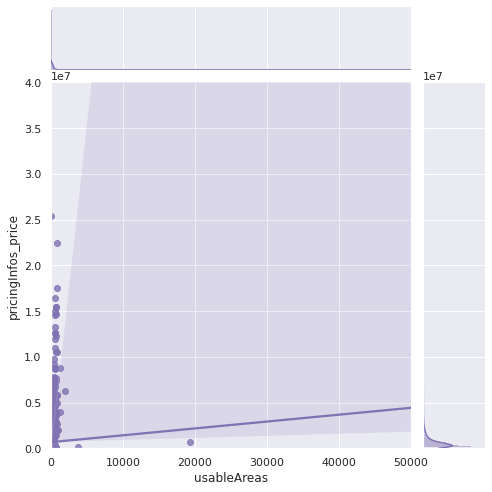

In [247]:
#amostra de 15%
sns.set_theme(style="darkgrid")
g = sns.jointplot(x="usableAreas", y="pricingInfos_price"
                  ,data=dataset.sample(round(dataset.shape[0]*.15), random_state=seed)
                  ,kind="reg", truncate=False
                  ,xlim=(0, 50000)
                  ,ylim=(0, 40000000)
                  ,color="m", height=7)

In [180]:
dataset.pricingInfos_price.describe()

count      72230.000
mean      678465.475
std      1015815.473
min          106.000
25%       224000.000
50%       409500.000
75%       770000.000
max     74200000.000
Name: pricingInfos_price, dtype: float64

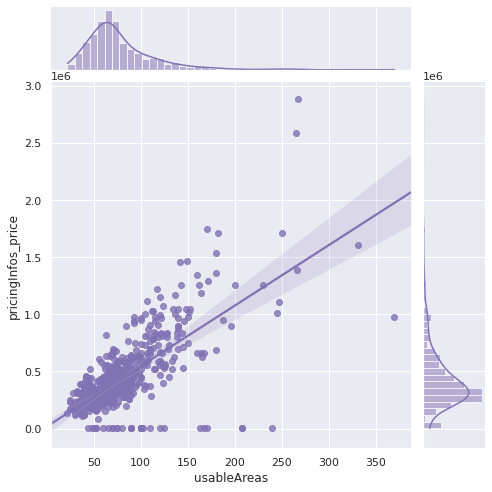

In [174]:
metro_df = dataset[dataset.title.str.contains('metrô', na=False)]

g = sns.jointplot(x="usableAreas", y="pricingInfos_price"
                  ,data=metro_df
                  ,kind="reg", truncate=False
                  ,color="m", height=7)